In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from io import StringIO
import pydotplus

# Pipelines
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as imbPipeline

# Models
from sklearn.svm import LinearSVC, SVC
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from IPython.display import Image  
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor


# Preprocessing
from imblearn.under_sampling import NearMiss, InstanceHardnessThreshold
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer
from imblearn.combine import SMOTEENN 
from imblearn.combine import SMOTETomek

# Metrics, model evaluation
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, log_loss
from sklearn.metrics import auc, roc_curve, roc_auc_score, precision_recall_curve
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_score, cross_val_predict
import sklearn.metrics as metrics

In [2]:
plt.rcParams["figure.figsize"] = (10, 10)

In [3]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')


In [4]:
pd.set_option('display.max_columns', None)

In [5]:
def model_results_tr_ts(model, X_train, y_train, X_test, y_test, name):
    """
    Function to evaluate one or multiple models and check train and test results with parameters set.
    
    Model fitting is done inside of the function.
    
    The function takes model, split data, and model name and returns the results on test and train sets. 
    Test set: confusion matrix, classification report. 
    Train and test sets: dataframe with accuracy, precision, recall, F1 score, and rocauc 
    score done with cross-validation.
    """
    print(f'**{name}** results', '\n')
    
    model.fit(X_train, y_train)
    y_pred_train = model.predict(X_train)
    y_pred_test  = model.predict(X_test)
    
    # Confusion matrix
    cf_matrix = confusion_matrix(y_test, y_pred_test)
    
    # Visualizing confusion matrix
    print(f'Confusion Matrix of test data')
    group_names  = ['TN', 'FP', 'FN', 'TP']
    group_counts = ['{0:0.0f}'.format(value) for value in cf_matrix.flatten()]
    labels       = [f'{v1}\n{v2}' for v1, v2 in zip(group_names, group_counts)]
    labels       = np.asarray(labels).reshape(2,2)
    fig, ax      = plt.subplots(figsize=(8,5))
    sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='BuGn', ax=ax)
    plt.show()
    
    # Classification report
    print(f'Classifictation Report of test data', '\n')
    print(classification_report(y_test, y_pred_test),'\n')
    
    # Main metrics with cross_val_score
    print(f'Main model evaluation metrics with cross validation (train and test data)','\n')
    strat_k_fold   = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    accuracy       = np.mean(cross_val_score(model, X_train, y_train, cv=strat_k_fold, scoring='accuracy'))
    precision      = np.mean(cross_val_score(model, X_train, y_train, cv=strat_k_fold, scoring='precision'))
    recall         = np.mean(cross_val_score(model, X_train, y_train, cv=strat_k_fold, scoring='recall'))
    f1score        = np.mean(cross_val_score(model, X_train, y_train, cv=strat_k_fold, scoring='f1'))
    rocauc         = np.mean(cross_val_score(model, X_train, y_train, cv=strat_k_fold, scoring='roc_auc'))
    
    df_model_train = pd.DataFrame({'data'         : 'train',
                                   'model'        : [name],
                                   'accuracy'     : [accuracy],
                                   'precision'    : [precision],
                                   'recall'       : [recall],
                                   'f1score'      : [f1score],
                                   'rocauc'       : [rocauc]})
   
    accuracy      = np.mean(cross_val_score(model, X_test, y_test, cv=strat_k_fold, scoring='accuracy'))
    precision     = np.mean(cross_val_score(model, X_test, y_test, cv=strat_k_fold, scoring='precision'))
    recall        = np.mean(cross_val_score(model, X_test, y_test, cv=strat_k_fold, scoring='recall'))
    f1score       = np.mean(cross_val_score(model, X_test, y_test, cv=strat_k_fold, scoring='f1'))
    rocauc        = np.mean(cross_val_score(model, X_test, y_test, cv=strat_k_fold, scoring='roc_auc'))
    
    df_model_test = pd.DataFrame({'data'         : 'test',
                                  'model'        : [name],
                                  'accuracy'     : [accuracy],
                                  'precision'    : [precision],
                                  'recall'       : [recall],
                                  'f1score'      : [f1score],
                                  'rocauc'       : [rocauc]})
    
    df_model = pd.concat([df_model_train, df_model_test], ignore_index=True)
    
    print(df_model.to_string())

In [6]:

def model_results_test_df(model, X_train, y_train, X_test, y_test, model_name):
    """
    Function to evaluate multiple models on test data with parameters set.
    
    Model fitting is done inside of the function.
    
    The function takes model, split data and the name of the model and returns the results of the test 
    data: dataframe with accuracy, precision, recall, F1 score and rocauc score done with 
    cross-validation.
    """
    model.fit(X_train, y_train)
    y_pred_test = model.predict(X_test)
    
    # Main metrics with cross_val_score
    strat_k_fold   = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    accuracy       = np.mean(cross_val_score(model, X_test, y_test, cv=strat_k_fold, scoring='accuracy'))
    precision      = np.mean(cross_val_score(model, X_test, y_test, cv=strat_k_fold, scoring='precision'))
    recall         = np.mean(cross_val_score(model, X_test, y_test, cv=strat_k_fold, scoring='recall'))
    f1score        = np.mean(cross_val_score(model, X_test, y_test, cv=strat_k_fold, scoring='f1'))
    rocauc         = np.mean(cross_val_score(model, X_test, y_test, cv=strat_k_fold, scoring='roc_auc'))
    
    df_model_test  = pd.DataFrame({'data'         : 'test',
                                   'model'        : [model_name],
                                   'accuracy'     : [accuracy],
                                   'precision'    : [precision],
                                   'recall'       : [recall],
                                   'f1score'      : [f1score],
                                   'rocauc'       : [rocauc]})
    
    return df_model_test

In [7]:
def model_results_test_cm_cr_df(model, X_train, y_train, X_test, y_test, model_name):
    """
    Function to evaluate multiple models on test data with parameters set.
    
    Model fitting is done inside of the function.
    
    The function takes model, test data (X and y) and model name and returns the results on test set:
    confusion matrix, classification report and dataframe with accuracy, precision, recall, F1 score
    and rocauc score done with cross-validation.
    """
    model.fit(X_train, y_train)
    print('\n', f'**{model_name}** results', '\n')
    y_pred_test = model.predict(X_test)
    
    # Confusion matrix
    cf_matrix = confusion_matrix(y_test, y_pred_test)
    
    # Visualizing confusion matrix
    print(f'Confusion Matrix of test data')
    group_names  = ['TN', 'FP', 'FN', 'TP']
    group_counts = ['{0:0.0f}'.format(value) for value in cf_matrix.flatten()]
    labels       = [f'{v1}\n{v2}' for v1, v2 in zip(group_names, group_counts)]
    labels       = np.asarray(labels).reshape(2,2)
    fig, ax      = plt.subplots(figsize=(8,5))
    sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='BuGn', ax=ax)
    plt.show()
    
    # Classification report
    print(f'Classifictation Report of test data', '\n')
    print(classification_report(y_test, y_pred_test),'\n')
    
    # Main metrics with cross_val_score
    strat_k_fold   = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    accuracy       = np.mean(cross_val_score(model, X_test, y_test, cv=strat_k_fold, scoring='accuracy'))
    precision      = np.mean(cross_val_score(model, X_test, y_test, cv=strat_k_fold, scoring='precision'))
    recall         = np.mean(cross_val_score(model, X_test, y_test, cv=strat_k_fold, scoring='recall'))
    f1score        = np.mean(cross_val_score(model, X_test, y_test, cv=strat_k_fold, scoring='f1'))
    rocauc         = np.mean(cross_val_score(model, X_test, y_test, cv=strat_k_fold, scoring='roc_auc'))
    
    df_model_test  = pd.DataFrame({'data'         : 'test',
                                   'model'        : [model_name],
                                   'accuracy'     : [accuracy],
                                   'precision'    : [precision],
                                   'recall'       : [recall],
                                   'f1score'      : [f1score],
                                   'rocauc'       : [rocauc]})
    
    return df_model_test

In [8]:

def model_results_test_cm_df(model, X_train, y_train, X_test, y_test, model_name):
    """
    Function to evaluate multiple models on test data with parameters set.
    
    Model fitting is done inside of the function.
    
    The function takes the model, split data and the model name and returns the results on the 
    test set:
    confusion matrix and the dataframe with accuracy, precision, recall, F1 score
    and rocauc score done with cross-validation.
    """
    model.fit(X_train, y_train)
    print('\n', f'**{model_name}** results', '\n')
    y_pred_test = model.predict(X_test)
    
    # Confusion matrix
    cf_matrix = confusion_matrix(y_test, y_pred_test)
    
    # Visualizing confusion matrix
    print(f'Confusion Matrix of test data')
    group_names  = ['TN', 'FP', 'FN', 'TP']
    group_counts = ['{0:0.0f}'.format(value) for value in cf_matrix.flatten()]
    labels       = [f'{v1}\n{v2}' for v1, v2 in zip(group_names, group_counts)]
    labels       = np.asarray(labels).reshape(2,2)
    fig, ax      = plt.subplots(figsize=(8,5))
    sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='BuGn', ax=ax)
    plt.show()
    
    # Main metrics with cross_val_score
    strat_k_fold   = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    accuracy       = np.mean(cross_val_score(model, X_test, y_test, cv=strat_k_fold, scoring='accuracy'))
    precision      = np.mean(cross_val_score(model, X_test, y_test, cv=strat_k_fold, scoring='precision'))
    recall         = np.mean(cross_val_score(model, X_test, y_test, cv=strat_k_fold, scoring='recall'))
    f1score        = np.mean(cross_val_score(model, X_test, y_test, cv=strat_k_fold, scoring='f1'))
    rocauc         = np.mean(cross_val_score(model, X_test, y_test, cv=strat_k_fold, scoring='roc_auc'))
    
    df_model_test  = pd.DataFrame({'data'         : 'test',
                                   'model'        : [model_name],
                                   'accuracy'     : [accuracy],
                                   'precision'    : [precision],
                                   'recall'       : [recall],
                                   'f1score'      : [f1score],
                                   'rocauc'       : [rocauc]})
    
    return df_model_test

In [9]:

def model_results_hyp_test_cm_cr_df(model, X_test, y_test, model_name):
    """
    Function to evaluate one or multiple models on test set with hyperparameter tuning.
    
    Model fitting is done outside of the function (when doing grid search).
    
    The function takes model, test data (X and y) and model name and returns the results on test set:
    confusion matrix, classification report and dataframe with accuracy, precision, recall, F1 score
    and rocauc score done with cross-validation.
    """
    print('\n', f'**{model_name}** results', '\n')
    y_pred_test = model.predict(X_test)
    
    # Confusion matrix
    cf_matrix = confusion_matrix(y_test, y_pred_test)
    
    # Visualizing confusion matrix
    print(f'Confusion Matrix of test data')
    group_names  = ['TN', 'FP', 'FN', 'TP']
    group_counts = ['{0:0.0f}'.format(value) for value in cf_matrix.flatten()]
    labels       = [f'{v1}\n{v2}' for v1, v2 in zip(group_names, group_counts)]
    labels       = np.asarray(labels).reshape(2,2)
    fig, ax      = plt.subplots(figsize=(8,5))
    sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='BuGn', ax=ax)
    plt.show()
    
    # Classification report
    print(f'Classifictation Report of test data', '\n')
    print(classification_report(y_test, y_pred_test),'\n')
    
    # Main metrics with cross_val_score
    strat_k_fold   = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    accuracy       = np.mean(cross_val_score(model, X_test, y_test, cv=strat_k_fold, scoring='accuracy'))
    precision      = np.mean(cross_val_score(model, X_test, y_test, cv=strat_k_fold, scoring='precision'))
    recall         = np.mean(cross_val_score(model, X_test, y_test, cv=strat_k_fold, scoring='recall'))
    f1score        = np.mean(cross_val_score(model, X_test, y_test, cv=strat_k_fold, scoring='f1'))
    rocauc         = np.mean(cross_val_score(model, X_test, y_test, cv=strat_k_fold, scoring='roc_auc'))
    
    df_model_test  = pd.DataFrame({'data'         : 'test',
                                   'model'        : [model_name],
                                   'accuracy'     : [accuracy],
                                   'precision'    : [precision],
                                   'recall'       : [recall],
                                   'f1score'      : [f1score],
                                   'rocauc'       : [rocauc]})
    
    return df_model_test


Introduction
After exploring and preprocessing our data we are ready to start working with Machine Learning algorithms. Before diving into models, let's define what problem we have, what models should be used, and which metrics will be used for evaluation.

We have a binary classification problem, we want to predict if a customer is going to churn after the first month or not (two classes).
We will be using supervised machine learning models. We will train our model with historical data that has an outcome specified.
The best metric in our case is F1 score, which shows the balance between precision and recall. We will also be using the confusion matrix to see how many customers have fallen under correct categories (True Positive and True Negative) and how many were mistaken (False Positive and False Negative). 
In the case of improving precision or recall, we will be focusing on improving recall. High precision relates to a low False Positive rate, and high recall relates to a low False Negative rate. The lower False Negative rate, the better. In our case, False Negative entries indicate that the customers will not churn but actually they will. Thinking that customer is not going to churn, we are losing opportunities because we are not putting appropriate attention to his/hers case. It means that to recover this loss, we would need to invest more, to again acquire a new customer. 

In [10]:
df=pd.read_csv(r"C:\Users\Álvaro\Final-project\Data\df_CM_.csv")

df.head()

,Comercio,sale,sessions,quote,inauguration_year,furnitureWithEquipment,merchandise,surface,gross_income,alimentacion-y-dietetica,arte-y-entretenimiento,automocion,calzado-marroqueria-y-piel,confecciones-y-textiles,construccion-y-reformas,deportes-y-ocio,educacion,electronica-y-maquinaria,fabricacion,hosteleria-y-restauracion,muebles-decoracion-y-menaje-hogar,negocio-inmobiliario,peluquerias-y-centros-estetica,profesionales-economia,profesionales-oficina,rc-tecnicas-y-profesionales,servicios-generales,servicios-sanitarios,transporte-y-almacenamiento,varios,Andalusia,Aragon,Asturias,Balearic_Islands,Basque_Country,Canary_Islands,Cantabria,Castile-La_Mancha,Castile_and_Leon,Catalonia,Ceuta,Community_of_Madrid,Extremadura,Galicia,La_Rioja,Madrid,Murcia,Navarre,Region_of_Murcia,Valencian_Community,GoogleDisplay,SingularC.email.billage,adwords,bing,facebook,hs_automation,hubspot,trustpilot
0,0.0,0,2.0,1,0.0,0.0,0.0,0.0,30000.0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0.0,0,6.0,1,0.0,0.0,0.0,0.0,30000.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
2,0.0,0,2.0,0,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
3,0.0,0,1.0,0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0
4,0.0,0,1.0,0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0


In [11]:
df.shape

(7289, 58)

# Data preprocessing


In [12]:
X = df.drop(columns='sale')
y = df['sale']
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.4)

print(f'Training data shape X: {X_train.shape}')


print(f'Testing data shape X: {X_test.shape}')

Training data shape X: (4373, 57)
Testing data shape X: (2916, 57)


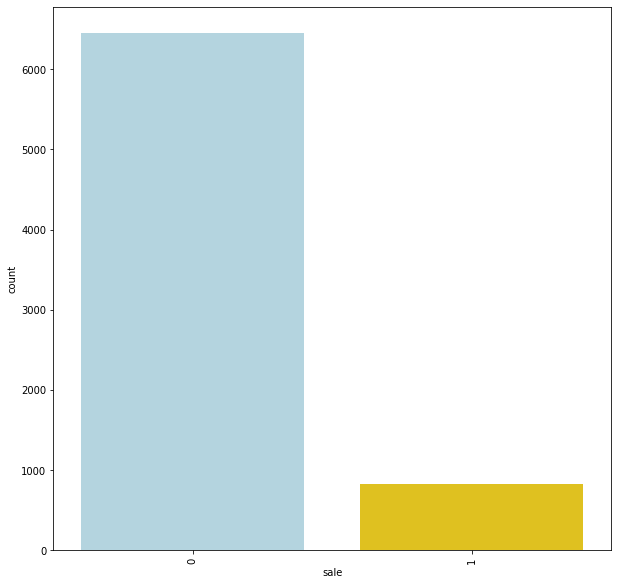

The split between two classes (sale and not sale):
0    88.57
1    11.43
Name: sale, dtype: float64


In [13]:
ax = sns.countplot(data=df, x='sale', palette={1: "Gold", 0: "Lightblue"})
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.show()

val_counts = round(df.sale.value_counts(normalize=True)*100, 2)
print(f'The split between two classes (sale and not sale):\n{val_counts}')

# Model selection

**RandomForestClassifier** results 

Confusion Matrix of test data


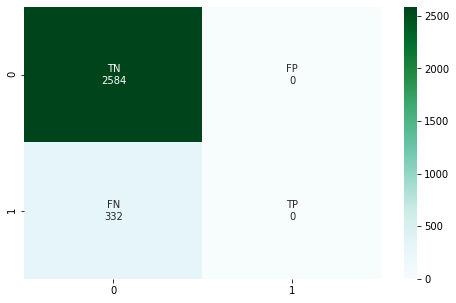

Classifictation Report of test data 

              precision    recall  f1-score   support

           0       0.89      1.00      0.94      2584
           1       0.00      0.00      0.00       332

    accuracy                           0.89      2916
   macro avg       0.44      0.50      0.47      2916
weighted avg       0.79      0.89      0.83      2916
 

Main model evaluation metrics with cross validation (train and test data) 

    data                   model  accuracy  precision  recall  f1score    rocauc
0  train  RandomForestClassifier  0.885433        0.0     0.0      0.0  0.624802
1   test  RandomForestClassifier  0.886146        0.0     0.0      0.0  0.625521


In [14]:

estimator = RandomForestClassifier(criterion='entropy', 
                                   max_depth=2, 
                                   max_features='auto', 
                                   n_estimators=200, 
                                   random_state=42) 

estimator_name = 'RandomForestClassifier'

pipeline = Pipeline([('scaler', StandardScaler()), ('clf', estimator)])
model_results_tr_ts(pipeline, X_train, y_train, X_test, y_test, estimator_name)

In [15]:
feat_importances.nlargest(25)

NameError: name 'feat_importances' is not defined

In [18]:
feat_importance.nlargest(25).reset_index().index

NameError: name 'feat_importance' is not defined

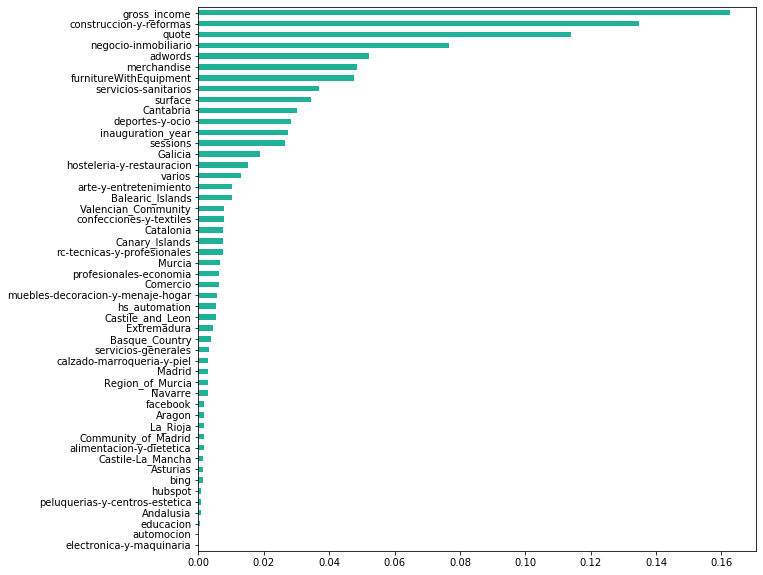

In [17]:
feat_importances = pd.Series(pipeline.steps[1][1].feature_importances_, 
                             index=df.drop(['sale'], axis=1).columns)

feat_importances.nlargest(50).sort_values().plot(kind='barh', color='#1fb299')
plt.show()

In [19]:
model = RandomForestClassifier(criterion='entropy', 
                               max_depth=2, 
                               max_features='auto', 
                               n_estimators=200, 
                               random_state=42) 
# Train
model.fit(X_train, y_train)

# Extract single tree
estimator = model.estimators_[2]

# Export as dot file
dot_data = StringIO()
export_graphviz(estimator, out_file=dot_data, 
                feature_names = df.drop(['sale'], axis=1).columns,
                class_names = ['not_churned', 'churned'],
                rounded=True, proportion=False, precision=2, filled=True)

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

InvocationException: GraphViz's executables not found

In [ ]:
X_train = StandardScaler().fit_transform(X_train)
X_test = StandardScaler().fit_transform(X_test)

In [ ]:
models = {'RandomForestClassifier': RandomForestClassifier(random_state=42),
          'ExtraTreesClassifier': ExtraTreesClassifier(random_state=42), 
          'LogisticRegression': LogisticRegression(random_state=42), 
          'SVC': SVC(random_state=42),
          'KNeighborsClassifier': KNeighborsClassifier(),
          'DecisionTreeClassifier': DecisionTreeClassifier(random_state=42),
          'LinearSVC': LinearSVC(random_state=42),
         }

models_df_test = pd.concat([model_results_test_df(model, X_train, y_train, X_test, y_test, name) for (name, model) in models.items()])
models_df_test.reset_index(inplace=True, drop=True)
models_df_test

# SMOTE 

Synthetic Minority Oversampling Technique (SMOTE). It works by selecting examples that are close in the feature space, drawing a line between the examples in the feature space and drawing a new sample at a point along that line.


In [20]:
oversamp_undersamp = SMOTETomek(sampling_strategy=0.6) #default sampling strategy
X_train_b, y_train_b = oversamp_undersamp.fit_sample(X_train, y_train)
X_train_b.shape, y_train_b.shape
y_train_b.value_counts()

0    3757
1    2208
Name: sale, dtype: int64

**RandomForestClassifier** results 

Confusion Matrix of test data


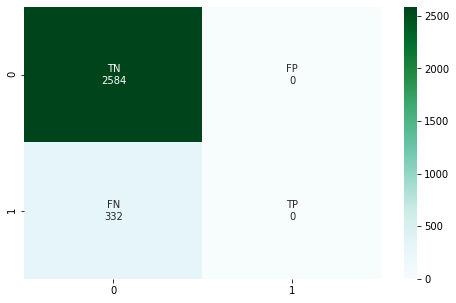

Classifictation Report of test data 

              precision    recall  f1-score   support

           0       0.89      1.00      0.94      2584
           1       0.00      0.00      0.00       332

    accuracy                           0.89      2916
   macro avg       0.44      0.50      0.47      2916
weighted avg       0.79      0.89      0.83      2916
 

Main model evaluation metrics with cross validation (train and test data) 

    data                   model  accuracy  precision  recall  f1score    rocauc
0  train  RandomForestClassifier  0.629841        0.0     0.0      0.0  0.758831
1   test  RandomForestClassifier  0.886146        0.0     0.0      0.0  0.625521


In [21]:

estimator = RandomForestClassifier(criterion='entropy', 
                                   max_depth=2, 
                                   max_features='auto', 
                                   n_estimators=200, 
                                   random_state=42) 

estimator_name = 'RandomForestClassifier'

pipeline = Pipeline([('scaler', StandardScaler()), ('clf', estimator)])
model_results_tr_ts(pipeline, X_train_b, y_train_b, X_test, y_test, estimator_name)

In [22]:
models = {'RandomForestClassifier': RandomForestClassifier(random_state=42),
          'ExtraTreesClassifier': ExtraTreesClassifier(random_state=42), 
          'LogisticRegression': LogisticRegression(random_state=42), 
          'SVC': SVC(random_state=42),
          'KNeighborsClassifier': KNeighborsClassifier(),
          'DecisionTreeClassifier': DecisionTreeClassifier(random_state=42),
          'LinearSVC': LinearSVC(random_state=42),
         }

models_df_test = pd.concat([model_results_test_df(model, X_train_b, y_train_b, X_test, y_test, name) for (name, model) in models.items()])
models_df_test.reset_index(inplace=True, drop=True)
models_df_test

,data,model,accuracy,precision,recall,f1score,rocauc
0,test,RandomForestClassifier,0.876548,0.323697,0.066350,0.109625,0.585809
1,test,ExtraTreesClassifier,0.864883,0.245371,0.087427,0.127647,0.578074
2,test,LogisticRegression,0.884431,0.000000,0.000000,0.000000,0.464650
3,test,SVC,0.886146,0.000000,0.000000,0.000000,0.586356
4,test,KNeighborsClassifier,0.871061,0.216889,0.051334,0.080020,0.555285
5,test,DecisionTreeClassifier,0.820986,0.183260,0.165491,0.173626,0.567129
6,test,LinearSVC,0.766433,0.095444,0.169561,0.098831,0.484785



 **RandomForestClassifier** results 

Confusion Matrix of test data


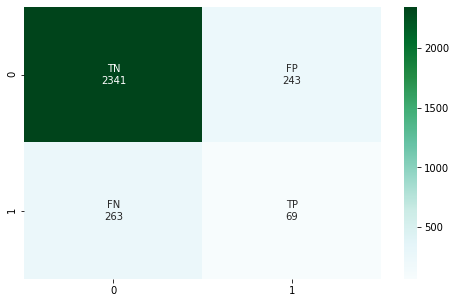

Classifictation Report of test data 

              precision    recall  f1-score   support

           0       0.90      0.91      0.90      2584
           1       0.22      0.21      0.21       332

    accuracy                           0.83      2916
   macro avg       0.56      0.56      0.56      2916
weighted avg       0.82      0.83      0.82      2916
 

Best parameters: {'criterion': 'gini', 'max_depth': 10, 'max_features': 'auto', 'n_estimators': 200}

 **ExtraTreesClassifier** results 

Confusion Matrix of test data


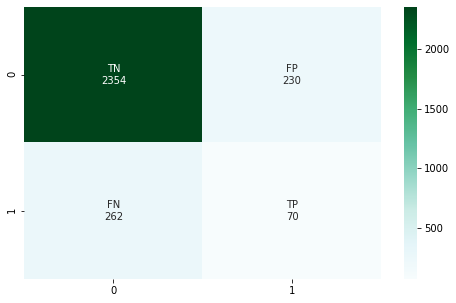

Classifictation Report of test data 

              precision    recall  f1-score   support

           0       0.90      0.91      0.91      2584
           1       0.23      0.21      0.22       332

    accuracy                           0.83      2916
   macro avg       0.57      0.56      0.56      2916
weighted avg       0.82      0.83      0.83      2916
 

Best parameters: {'max_features': 'log2', 'min_samples_split': 6, 'n_estimators': 50}

 **LogisticRegression** results 

Confusion Matrix of test data


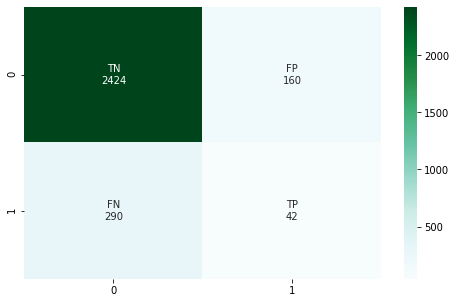

Classifictation Report of test data 

              precision    recall  f1-score   support

           0       0.89      0.94      0.92      2584
           1       0.21      0.13      0.16       332

    accuracy                           0.85      2916
   macro avg       0.55      0.53      0.54      2916
weighted avg       0.82      0.85      0.83      2916
 

Best parameters: {'C': 100.0, 'multi_class': 'ovr', 'penalty': 'l1', 'solver': 'liblinear'}

 **SVC** results 

Confusion Matrix of test data


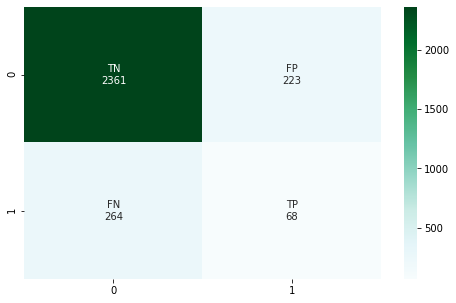

Classifictation Report of test data 

              precision    recall  f1-score   support

           0       0.90      0.91      0.91      2584
           1       0.23      0.20      0.22       332

    accuracy                           0.83      2916
   macro avg       0.57      0.56      0.56      2916
weighted avg       0.82      0.83      0.83      2916
 

Best parameters: {'C': 1, 'gamma': 1, 'kernel': 'rbf'}

 **KNeighborsClassifier** results 

Confusion Matrix of test data


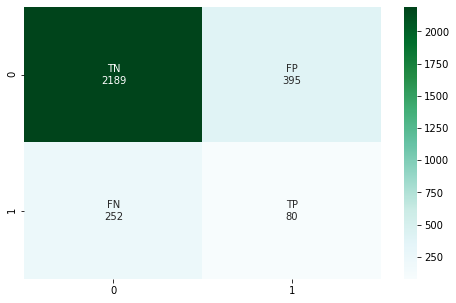

Classifictation Report of test data 

              precision    recall  f1-score   support

           0       0.90      0.85      0.87      2584
           1       0.17      0.24      0.20       332

    accuracy                           0.78      2916
   macro avg       0.53      0.54      0.53      2916
weighted avg       0.81      0.78      0.79      2916
 

Best parameters: {'metric': 'manhattan', 'n_neighbors': 5, 'weights': 'distance'}

 **DecisionTreeClassifier** results 

Confusion Matrix of test data


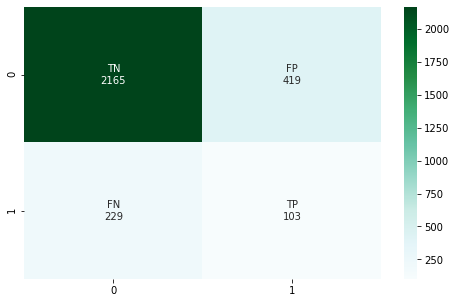

Classifictation Report of test data 

              precision    recall  f1-score   support

           0       0.90      0.84      0.87      2584
           1       0.20      0.31      0.24       332

    accuracy                           0.78      2916
   macro avg       0.55      0.57      0.56      2916
weighted avg       0.82      0.78      0.80      2916
 

Best parameters: {'criterion': 'gini', 'max_depth': 9, 'splitter': 'best'}

 **LinearSVC** results 

Confusion Matrix of test data


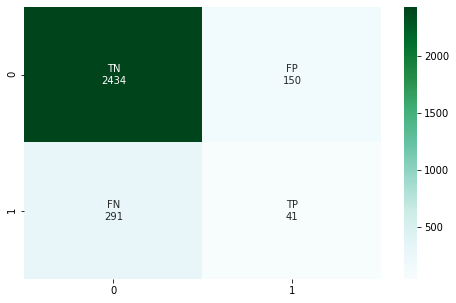

Classifictation Report of test data 

              precision    recall  f1-score   support

           0       0.89      0.94      0.92      2584
           1       0.21      0.12      0.16       332

    accuracy                           0.85      2916
   macro avg       0.55      0.53      0.54      2916
weighted avg       0.82      0.85      0.83      2916
 

Best parameters: {'C': 10.0, 'dual': 0, 'loss': 'squared_hinge', 'multi_class': 'ovr', 'penalty': 'l1'}


,data,model,accuracy,precision,recall,f1score,rocauc
0,test,RandomForestClassifier,0.885803,0.000000,0.000000,0.000000,0.633503
1,test,ExtraTreesClassifier,0.879631,0.341832,0.066305,0.110912,0.570235
2,test,LogisticRegression,0.885460,0.000000,0.000000,0.000000,0.613116
3,test,SVC,0.884432,0.358333,0.021031,0.039110,0.548785
4,test,KNeighborsClassifier,0.853229,0.162873,0.072275,0.099209,0.548200
5,test,DecisionTreeClassifier,0.864537,0.242436,0.078290,0.116084,0.568267
6,test,LinearSVC,0.885117,0.000000,0.000000,0.000000,0.613089


In [23]:
models = {'RandomForestClassifier': RandomForestClassifier(random_state=42),
          'ExtraTreesClassifier': ExtraTreesClassifier(random_state=42),
          'LogisticRegression': LogisticRegression(random_state=42), 
          'SVC': SVC(random_state=42),
          'KNeighborsClassifier': KNeighborsClassifier(),
          'DecisionTreeClassifier': DecisionTreeClassifier(random_state=42),
          'LinearSVC': LinearSVC(random_state=42),
         }

# Defining values for the parameters
random_grid = {'n_estimators': [100, 200, 300],
              'max_features': ['auto', 'sqrt', 'log2'],
              'max_depth' : [2, 5, 10],
              'criterion' :['gini', 'entropy']}

xgb_grid   = {'learning_rate': [0.01],
              'n_estimators': [300, 700],
              'max_depth':[7, 8],
              'reg_alpha':[0.3, 0.4]}

extra_grid = {'n_estimators': [20, 50, 100],
             'max_features': ['auto', 'sqrt', 'log2'],
             'min_samples_split': [2, 4, 6]}

lgbm_grid  = {'num_leaves': [10, 30, 50], 
             'min_child_samples': [20, 40, 60], 
             'min_child_weight': [1e-5, 1e-3, 1e-2],
             'reg_alpha': [1e-1, 5],
             'reg_lambda': [1e-1, 5]}

c_values   = list(10.0**np.arange(-3, 3))
log_grid   = [{'C': c_values,
              'penalty': ['l2'],
              'solver' : ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'],
              'multi_class': ['ovr', 'warn']},
              {'C': c_values,
              'penalty': ['l1'],
              'solver' : ['liblinear', 'saga'],
              'multi_class': ['ovr', 'warn']}]

svc_grid   = {'C': [0.1, 1],
              'gamma': [1, 0.1],
              'kernel': ['rbf']}

knn_grid   = {'n_neighbors': [5,7,9,11,13,15,17,19],
              'weights': ['uniform', 'distance'],
              'metric' : ['euclidean', 'manhattan']}

depth      = list(np.arange(2, 10))
dtree_grid = {'criterion': ['gini', 'entropy'],
              'splitter': ['best', 'random'],
              'max_depth' : depth}

c_values   = list(10.0**np.arange(-3, 3))
lsvc_grid  = [{'C': c_values,
              'multi_class': ['ovr', 'crammer_singer'],
              'penalty': ['l1'],
              'loss': ['squared_hinge'],
              'dual': [0]},
              {'C': c_values,
              'multi_class': ['ovr', 'crammer_singer'],
              'penalty': ['l2'],
              'loss': ['squared_hinge'],
              'dual': [1]}]


grids = [random_grid, extra_grid, log_grid, svc_grid, knn_grid, dtree_grid,lsvc_grid]

# Defining cv
strat_k_fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

appended_dfs = []
for (name, model), param_grid in zip (models.items(), grids):
    # Runing grid search
    grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=strat_k_fold, n_jobs=-1, 
                        scoring='f1')
    # Fitting the grid and use it to find the best estimator on train data
    grid.fit(X_train_b, y_train_b) 
    # Creating the variable for best etimator 
    best_estimator = grid.best_estimator_
    # Conducting model metrics on test data
    models_df_test = model_results_hyp_test_cm_cr_df(best_estimator, X_test, y_test, name)
    # Printing best parameters
    print(f'Best parameters: {grid.best_params_}')
    appended_dfs.append(models_df_test)

model_results_hyp = pd.concat(appended_dfs, ignore_index = True)
model_results_hyp


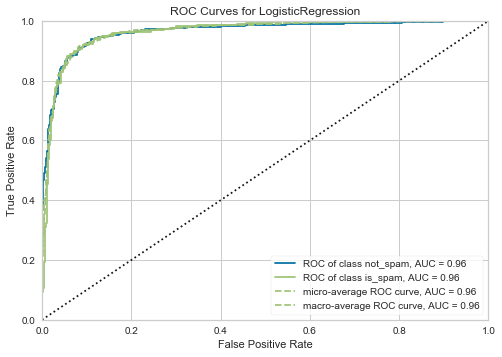

In [29]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

from yellowbrick.classifier import ROCAUC
from yellowbrick.datasets import load_spam

# Load the classification dataset

# Create the training and test data
X_train_b, X_test, y_train_b, y_test = train_test_split(X, y, random_state=42)

# Instantiate the visualizer with the classification model
model = LogisticRegression(multi_class="auto", solver="liblinear")
visualizer = ROCAUC(model, classes=["not_spam", "is_spam"])

visualizer.fit(X_train, y_train)        # Fit the training data to the visualizer
visualizer.score(X_test, y_test)        # Evaluate the model on the test data
visualizer.show()         